## Conservative Dynamics

### Semi-analytic Equations of Motion

Import `rebound` and `celmech` packages as well as other packages:

In [22]:
import rebound as rb
import celmech as cm
import scipy
import numpy as np
import matplotlib.pyplot as plt
import radvel
import pandas as pd

Import data:

In [25]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep =';')
hd_data.BJD -= 2.4e6

Params:

In [26]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

Get sim using least squares params:

In [27]:
def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 3], params[5*i + 4])  # omega from arctan of sesin, secos
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim


Create sim from params:

In [95]:
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = np.median(hd_data.BJD))
inner = sim.particles[1]
outer = sim.particles[2]

Construct Hamiltonian for the system:

In [96]:
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)

In [97]:
pham.H

-G**2*M2**2*mu2**3/(2*Lambda2**2) - G**2*M1**2*mu1**3/(2*Lambda1**2)

In [98]:
pham.add_eccentricity_MMR_terms(3, 1, max_order=3)

In [99]:
pham.H

-C_3,-2,-1,0,0,0^0,0,0,0;(1,2)*G**2*M2*m1*m2*mu2**2*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/Lambda2**2 - C_3,-2,-1,0,0,0^0,0,0,1;(1,2)*G**2*M2*m1*m2*mu2**2*(eta2**2 + kappa2**2)*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/Lambda2**3 - C_3,-2,-1,0,0,0^0,0,1,0;(1,2)*G**2*M2*m1*m2*mu2**2*(eta1**2 + kappa1**2)*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/(Lambda1*Lambda2**2) - C_3,-2,-1,0,0,0^0,1,0,0;(1,2)*G**2*M2*m1*m2*mu2**2*(rho2**2/2 + sigma2**2/2)*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/(2*Lambda2**3) - C_3,-2,-1,0,0,0^1,0,0,0;(1,2)*G**2*M2*m1*m2*mu2**2*(rho1**2/2 + sigma1**2/2)*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/(2*Lambda1*Lambda2**2) - C_3,-2,0,-1,0,0^0,0,0,0;(1,2)*G**2*M2*m1*m2*mu2**2*(eta2*sin(2*lamb

Integrate:

In [100]:
# Here we define the times at which we'll get simulation outputs
Nout = 150
times = np.linspace(0 , 3e3, Nout) * inner.P  # 3000 times the orbital period of teh inner planet

# These are the quantites we'll track in our rebound and celmech integrations
keys = ['l1','l2','pomega1','pomega2','e1','e2','a1','a2']

# These dictionaries will hold our results
rebound_results= {key:np.zeros(Nout) for key in keys}
celmech_results= {key:np.zeros(Nout) for key in keys}

# These are the lists of particles in both simulations
# for which we'll save quantities.
rb_particles = sim.particles
cm_particles = pvars.particles

In [101]:
for i,t in enumerate(times):
    sim.integrate(t) # advance N-body
    pham.integrate(t) # advance celmech
    for j,p_rb,p_cm in zip([1,2],rb_particles[1:],cm_particles[1:]):
        # store N-body results
        rebound_results["l{}".format(j)][i] = p_rb.l
        rebound_results["pomega{}".format(j)][i] = p_rb.pomega
        rebound_results["e{}".format(j)][i] = p_rb.e
        rebound_results["a{}".format(j)][i] = p_rb.a

        # store celmech results
        celmech_results["l{}".format(j)][i] = p_cm.l
        celmech_results["pomega{}".format(j)][i] = p_cm.pomega
        celmech_results["e{}".format(j)][i] = p_cm.e
        celmech_results["a{}".format(j)][i] = p_cm.a


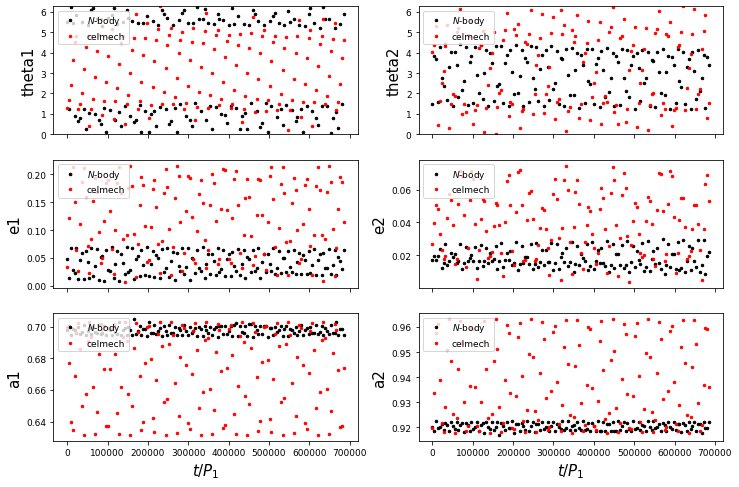

In [102]:
# First, we compute resonant angles for both sets of results
for d in [celmech_results,rebound_results]:
    d['theta1'] = np.mod(3 * d['l2'] - 2 * d['l1'] - d['pomega1'],2*np.pi)
    d['theta2'] = np.mod(3 * d['l2'] - 2 * d['l1'] - d['pomega2'],2*np.pi)

# Now we'll create a figure...
import matplotlib.pyplot as plt
fig,ax = plt.subplots(3,2,sharex = True,figsize = (12,8))
for i,q in enumerate(['theta','e','a']):
    for j in range(2):
        key = "{:s}{:d}".format(q,j+1)
        ax[i,j].plot(times,rebound_results[key],'k.',label='$N$-body')
        ax[i,j].plot(times,celmech_results[key],'r.',label='celmech')
        ax[i,j].set_ylabel(key,fontsize=15)
        ax[i,j].legend(loc='upper left')

#... and make it pretty
ax[0,0].set_ylim(0,2*np.pi);
ax[0,1].set_ylim(0,2*np.pi);
ax[2,0].set_xlabel(r"$t/P_1$",fontsize=15);
ax[2,1].set_xlabel(r"$t/P_1$",fontsize=15);